**Author** - [Amitrajit Bose](http://amitrajitbose.github.io) <br>
**Date Of Creation** - Jan 31, 2019 <br>
**Vectorization Method** - TF-IDF <br>
**Classifier** - [Linear Support Vector Machine](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) (LIBLINEAR)
**Dataset Details** <br>
- Total Row Count = 500000
- Rows Used In Notebook = 100000
- Test Ratio = 0.25

In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
# Any results you write to the current directory are saved as output.

['Reviews.csv', 'hashes.txt', 'database.sqlite']


In [23]:
df = pd.read_csv('../input/Reviews.csv',nrows=100000)
#df = df_full[:10000]
print("Dimension",df.shape)
df.head()

Dimension (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Brief Exploratory Data Analysis

In [24]:
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05
mean,50000.500000,1.639790,2.119960,4.152630,1.296225e+09
std,28867.657797,6.368915,6.991061,1.320141,4.782053e+07
min,1.000000,0.000000,0.000000,1.000000,9.486720e+08
25%,25000.750000,0.000000,0.000000,4.000000,1.270512e+09
50%,50000.500000,0.000000,1.000000,5.000000,1.311725e+09
75%,75000.250000,2.000000,2.000000,5.000000,1.332720e+09
max,100000.000000,559.000000,562.000000,5.000000,1.351210e+09


In [25]:
# Calculating length of reviews and adding it as a column
df['TextLength'] = df['Text'].apply(lambda x: len(x)-x.count(' '))
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,TextLength
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,215
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,160
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,411
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,177
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,111


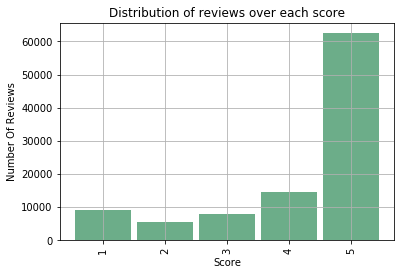

In [26]:
df.Score.value_counts().sort_index().plot.bar(alpha=0.7, grid=True, color = 'seagreen', width = 0.9)
plt.xlabel('Score')
plt.ylabel('Number Of Reviews')
plt.title('Distribution of reviews over each score')
plt.show()

In [27]:
# How many empty length texts are there ?
df[df['TextLength']==0].Text.count()

0

> This indicates that there are no empty rows of text content

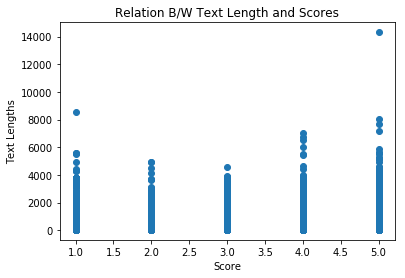

In [28]:
plt.scatter(df['Score'], df['TextLength'])
plt.xlabel('Score')
plt.ylabel('Text Lengths')
plt.title('Relation B/W Text Length and Scores')
plt.show()

> This indicates that there is no noteworthy correlation between text length and score.

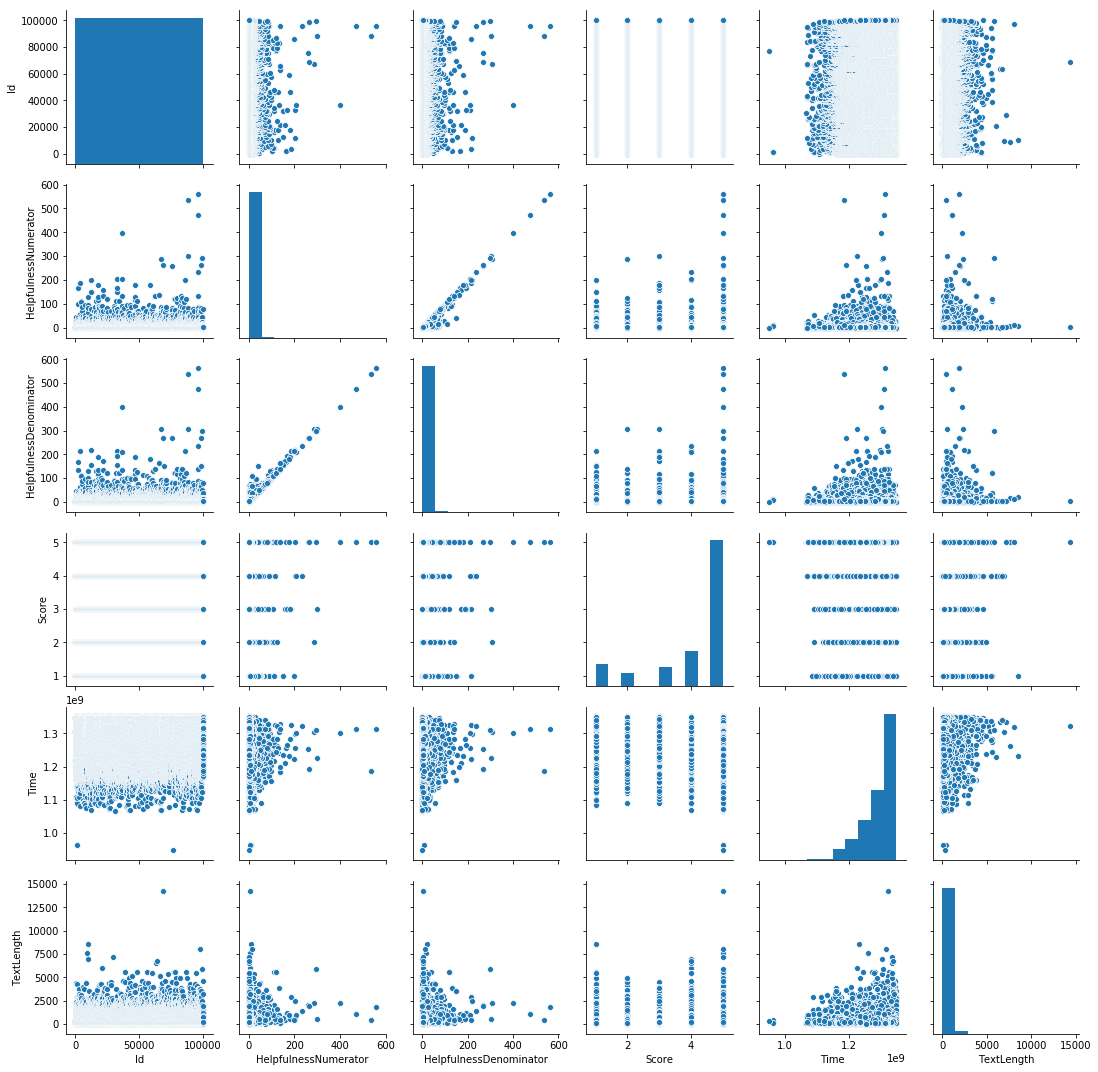

In [29]:
sns.pairplot(df)
plt.show()

## Data Preprocessing & Cleansing

In [30]:
import nltk
import string
from nltk.stem import PorterStemmer
import re
from nltk.corpus import stopwords
stopwords_en = set(stopwords.words('english'))
ps = PorterStemmer()

In [31]:
def clean_text(text):
    text = text.lower() #converting text to lowercase
    text = ' '.join([i for i in nltk.word_tokenize(text) if i not in stopwords_en and i not in string.punctuation]) #stopword and punct removal
    text = re.sub('[^a-z]+', ' ', text) #removal of anything other than English letters
    text = ' '.join([ps.stem(i) for i in nltk.word_tokenize(text)]) #stemming
    return text

In [32]:
# Apply the cleanup and create a new column
df['CleanText'] = df['Text'].apply(lambda x: clean_text(x))
df.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,TextLength,CleanText
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,215,bought sever vital can dog food product found ...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,160,product arriv label jumbo salt peanut peanut a...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,411,confect around centuri light pillowi citru gel...


In [33]:
def partition(val):
    if(val>2):
        return 1
    return 0
df['Positivity']=df['Score'].apply(lambda x: partition(x))
df.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,TextLength,CleanText,Positivity
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,215,bought sever vital can dog food product found ...,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,160,product arriv label jumbo salt peanut peanut a...,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,411,confect around centuri light pillowi citru gel...,1


In [34]:
required_columns = ['CleanText', 'Positivity']
df = df[required_columns]
df.head()

,CleanText,Positivity
0,bought sever vital can dog food product found ...,1
1,product arriv label jumbo salt peanut peanut a...,0
2,confect around centuri light pillowi citru gel...,1
3,look secret ingredi robitussin believ found go...,0
4,great taffi great price wide assort yummi taff...,1


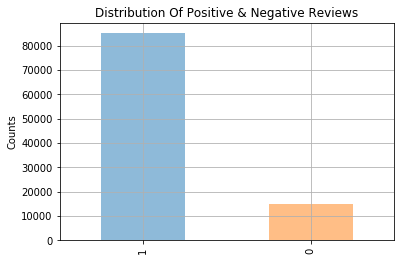

In [35]:
df.Positivity.value_counts().plot.bar(alpha=0.5, grid=True)
plt.title('Distribution Of Positive & Negative Reviews')
plt.ylabel('Counts')
plt.show()

## Train Test Split

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['CleanText'], df['Positivity'], test_size=0.25, random_state=42, shuffle=True, stratify=df['Positivity'])
print("Dataset Splitted ... \nTrain Set Size = {}\nTest Set Size  = {}".format(X_train.shape[0], X_test.shape[0]))

Dataset Splitted ... 
Train Set Size = 75000
Test Set Size  = 25000


## Text Vectorisation

Using TF-IDF Vectorizer

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectoriser = TfidfVectorizer()

# Training % Feature Extraction On Entire Dataset, Used For Cross Validation & Model Comparison
features = tfidf_vectoriser.fit_transform(df['CleanText'])
labelss = df['Positivity'].astype(int)

In [38]:
# Training On Only Train Set Now
tfidf_vectoriser.fit(X_train)
X_train_tf = tfidf_vectoriser.transform(X_train)
X_test_tf = tfidf_vectoriser.transform(X_test)
X_train_tf.shape, X_test_tf.shape

((75000, 32617), (25000, 32617))

In [39]:
import random
print("Ten Random Words from Training Set ...\n",*random.sample(tfidf_vectoriser.get_feature_names(),10))

Ten Random Words from Training Set ...
 madhous tast thusfar pawnaturaw lefs pop inexpedi silverfish lambrusco mista


### Top Most Prominent Features
By Chi-Square Feature Selection

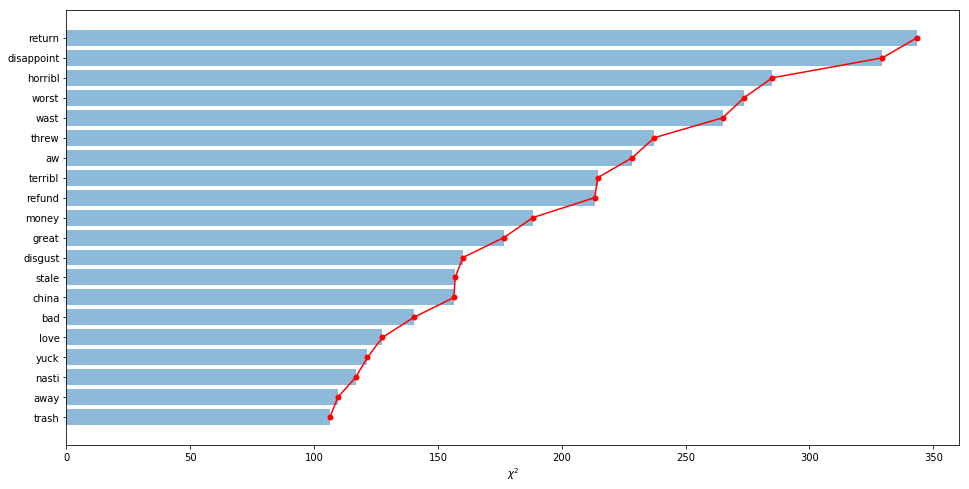

In [40]:
from sklearn.feature_selection import chi2
chi2score = chi2(X_train_tf, y_train)[0]
plt.figure(figsize=(16,8))
scores = list(zip(tfidf_vectoriser.get_feature_names(), chi2score))
chi2 = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*chi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, color='r')
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')
plt.show();

## Compare Various Classification Models

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

In [42]:
models = [
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=0)
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features ,labelss, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

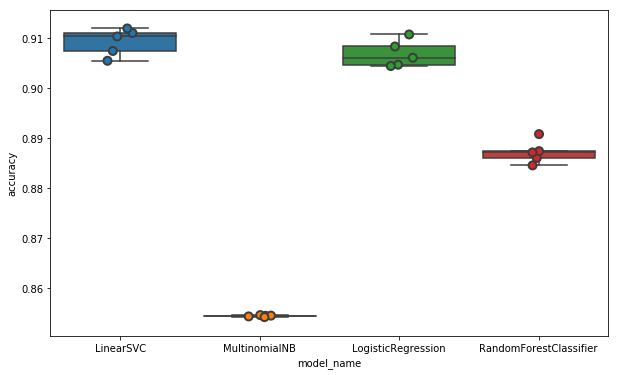

In [43]:
plt.figure(figsize=(10,6))
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

## Tuning Hyperparameters

In [44]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'C':[0.5,0.8,1.0,1.5]
}
svm = LinearSVC(max_iter=1500)
svm_cv = GridSearchCV(svm, param_grid, cv=5)
svm_cv.fit(features, labelss)
print("Best Parameters :", svm_cv.best_params_)
print("Best Score :",svm_cv.best_score_)

Best Parameters : {'C': 0.5}
Best Score : 0.9105


In [45]:
svm = LinearSVC(C=0.5, max_iter=2000)
svm.fit(X_train_tf, y_train)

LinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=2000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

## Evaluation Metrics

In [46]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
y_pred = svm.predict(X_test_tf)
print(classification_report(y_test, y_pred, target_names=['Negative','Positive']))
print("Accuracy :",accuracy_score(y_test, y_pred), end='\n\n')
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

              precision    recall  f1-score   support

    Negative       0.79      0.57      0.66      3722
    Positive       0.93      0.97      0.95     21278

   micro avg       0.91      0.91      0.91     25000
   macro avg       0.86      0.77      0.81     25000
weighted avg       0.91      0.91      0.91     25000

Accuracy : 0.91284

[[ 2117  1605]
 [  574 20704]]


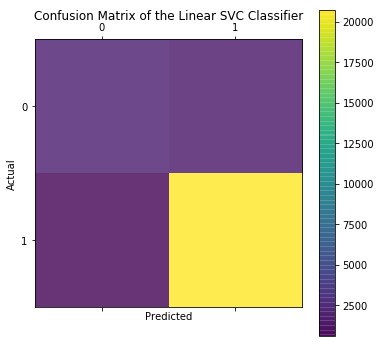

In [47]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, alpha=0.8)
plt.title('Confusion Matrix of the Linear SVC Classifier')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

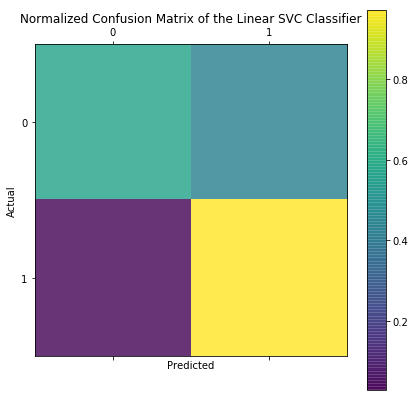

In [48]:
cm_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
cax = ax.matshow(cm_normalized, alpha=0.8)
plt.title('Normalized Confusion Matrix of the Linear SVC Classifier')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [49]:
from sklearn.calibration import CalibratedClassifierCV
cclf = CalibratedClassifierCV(base_estimator=svm, cv="prefit")
cclf.fit(X_train_tf, y_train)

CalibratedClassifierCV(base_estimator=LinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=2000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
            cv='prefit', method='sigmoid')

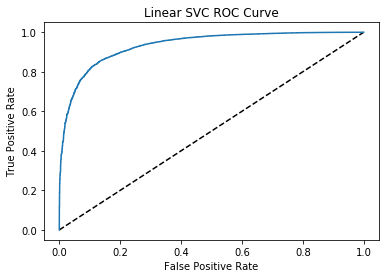

ROC AUC Score : 0.9338517268822106


In [50]:
y_pred_prob = cclf.predict_proba(X_test_tf)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Linear SVC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Linear SVC ROC Curve')
plt.show();
print("ROC AUC Score :", roc_auc_score(y_test, y_pred_prob))

**Remarks** <br>
We can improve the accuracy with non-linear classifiers and neural networks like LSTM. This is a simple approach backed by good data preprocessing.